# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(azdias.head(3))
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
#missing_val =azdias.isnull().sum().sum()
#print('Total Missing Values:',missing_val)


In [5]:
def missing(missing_or_unknown):
    new_list = list()
    for values in missing_or_unknown:
        new_list.append(values[1:-1].split(","))
    return new_list
missing_values = missing(feat_info["missing_or_unknown"])

In [6]:
for attribute,missing_values_list in zip(feat_info['attribute'], missing_values):
    if missing_values_list[0] != "":
        for missing_value in missing_values_list:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan

In [7]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nulls = azdias.isnull().sum()
nulls.sort_values(ascending = True, inplace = True)

nulls

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [9]:
nulls.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

Text(0,0.5,'Column Number')

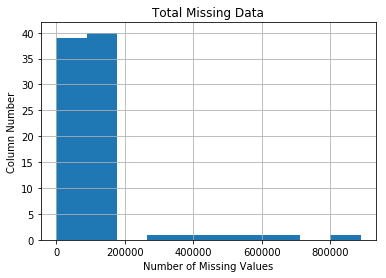

In [10]:
# Investigate patterns in the amount of missing data in each column.
nulls.hist()
plt.title('Total Missing Data')
plt.xlabel('Number of Missing Values')
plt.ylabel('Column Number')


In the histogram above we are looking at missing values. From this data it seems that we need to address the columns that are missing more than 200000 values.

We need to create a percentage for these columns so we can easily compare them in a future analysis.

In [11]:
high_nulls = nulls[nulls>200000]
print(high_nulls)

ALTER_HH        310267
GEBURTSJAHR     392318
KBA05_BAUMAX    476524
KK_KUNDENTYP    584612
AGER_TYP        685843
TITEL_KZ        889061
dtype: int64


Text(0,0.5,'Number of Columns')

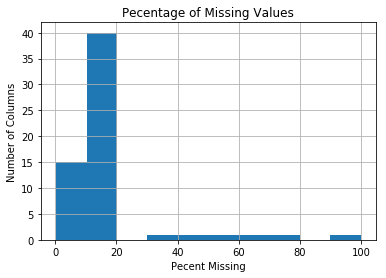

In [12]:
#convert to percent
nulls = nulls[nulls>0]/(azdias.shape[0])*100

#plot the percents
nulls.hist()
plt.title('Pecentage of Missing Values')
plt.xlabel('Pecent Missing')
plt.ylabel('Number of Columns')


In [13]:
#need to check percentage values to determine what is outlier
nulls

ALTERSKATEGORIE_GROB      0.323264
GFK_URLAUBERTYP           0.544646
LP_STATUS_GROB            0.544646
LP_STATUS_FEIN            0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
CJT_GESAMTTYP             0.544646
HH_EINKOMMEN_SCORE        2.058749
WOHNDAUER_2008            8.247000
ANZ_TITEL                 8.247000
SOHO_KZ                   8.247000
ANZ_PERSONEN              8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
GEBAEUDETYP              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
BALLRAUM                 10.518154
EWDICHTE                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

It seems like anything above 18 percent is an outlier

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
to_drop = nulls[nulls>18].index

#we will remove these

In [15]:
#we want to drop those high null counts
azdias.drop(columns = to_drop, axis='columns', inplace=True)

In [16]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
Above are the outlier columns with most of the missing data. It is safe to advise that we remove these columns to avoid our dataset being altered. We did remove all columns that had more than 18% missing

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
rows_missing = azdias.isnull().sum(axis = 1)
rows_missing.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

Text(0,0.5,'Number of Rows')

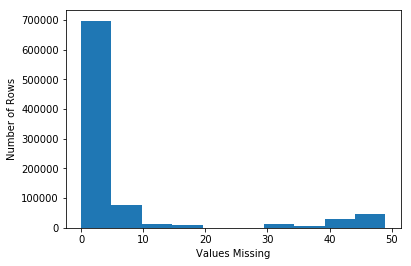

In [18]:
plt.hist(rows_missing)
plt.xlabel('Values Missing')
plt.ylabel('Number of Rows')

Based on the histogram above we should split our data in two datasets with the value of 30 being our middle ground.

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
value_under_30 = azdias[rows_missing < 30]
value_over_30 = azdias[rows_missing >= 30]


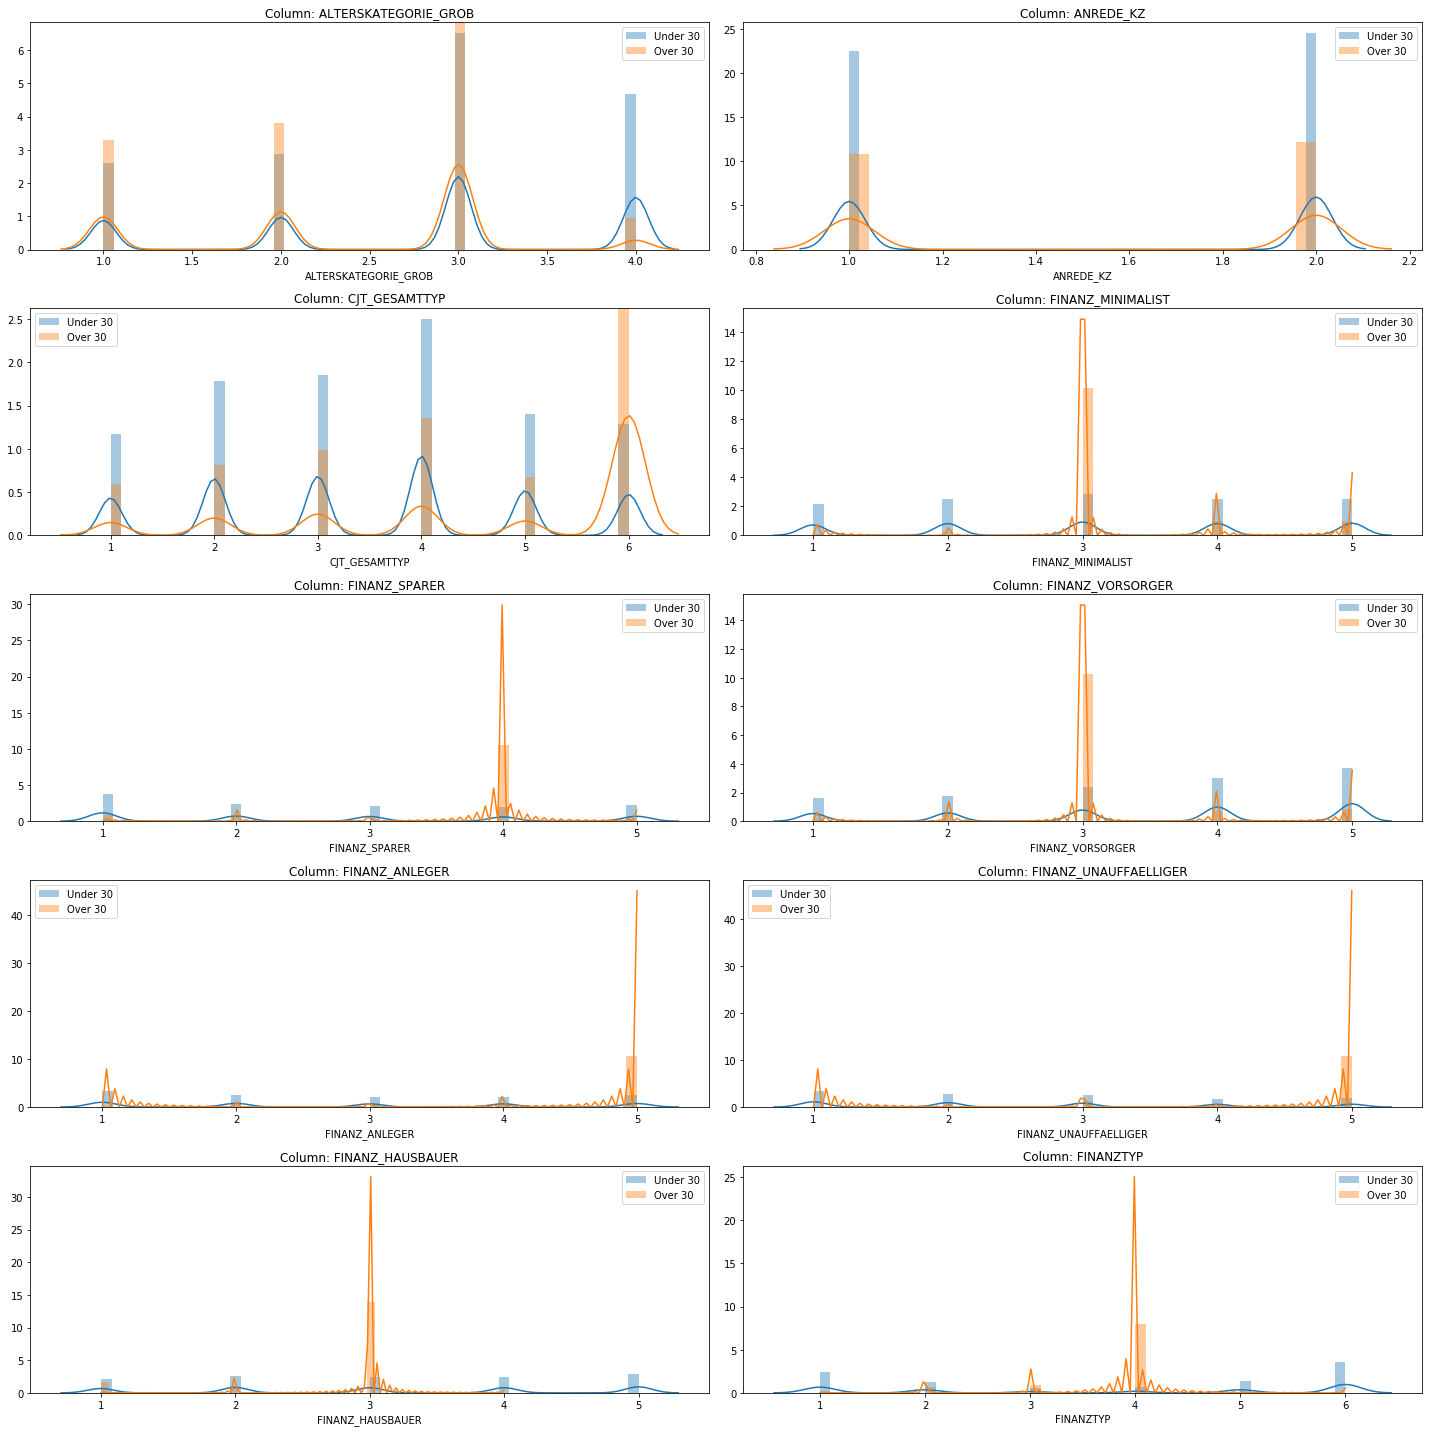

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
#lets create a function so we can easily compare in the future

plt.figure(figsize = (20, 20))

for i, col in enumerate(azdias.columns[:10]):
    plt.subplot(5,2,i+1)
    sns.distplot(value_under_30[col][value_under_30[col].notnull()], label = 'Under 30')
    sns.distplot(value_over_30[col][value_over_30[col].notnull()], label = 'Over 30')
    
    plt.title("Column: {}".format(col))
    plt.tight_layout()
    plt.legend();

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at the graphs above is does seem that the difference between the two is vast. It is safe to say we can drop the data with many missing values.  

In [21]:
value_under_30 = value_under_30.fillna(value_under_30.mode().iloc[0])

In [22]:
value_under_30.isnull().sum(axis=1)

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
20        0
21        0
22        0
23        0
25        0
26        0
27        0
28        0
29        0
31        0
32        0
33        0
34        0
36        0
         ..
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Length: 798061, dtype: int64

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
#we need to create a variable to store this
feat_info =feat_info[feat_info.attribute.isin(value_under_30.columns)]



In [24]:
#show our isna values under 30
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info[feat_info.type == 'categorical'].attribute
cat_level = value_under_30[cat_features].nunique()
#first lets look at the categorical data
print(cat_features)


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
#store out values
cat_multi = []
cat_binary = []
#adding some logic to see what all features are being processed
for feature in cat_features:
    if feature in azdias.columns:
        print('processing:', feature)
        if azdias[feature].nunique() > 2:
            cat_multi.append(feature)
        else:
            cat_binary.append(feature)
    else:
        print('Column', feature, 'not found')
        


processing: ANREDE_KZ
processing: CJT_GESAMTTYP
processing: FINANZTYP
processing: GFK_URLAUBERTYP
processing: GREEN_AVANTGARDE
processing: LP_FAMILIE_FEIN
processing: LP_FAMILIE_GROB
processing: LP_STATUS_FEIN
processing: LP_STATUS_GROB
processing: NATIONALITAET_KZ
processing: SHOPPER_TYP
processing: SOHO_KZ
processing: VERS_TYP
processing: ZABEOTYP
processing: GEBAEUDETYP
processing: OST_WEST_KZ
processing: CAMEO_DEUG_2015
processing: CAMEO_DEU_2015


In [27]:
#features are too high for PCA so going to drop some
drop_features = cat_level[cat_level > 20].index
value_under_30.drop(drop_features, axis=1, inplace=True)

for feature in drop_features:
    cat_multi.remove(feature)

In [28]:
#return a count
for col in cat_binary:
    print(value_under_30[col].value_counts())

2.0    416177
1.0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [29]:
#to clean these up we will need to replace the values so they are standardized
#had issues with this, running iloc[] fixed this issue
value_under_30['ANREDE_KZ'].replace({2:0, 1:1}, inplace = True)
value_under_30['SOHO_KZ'].replace({0.0:0,1.0:1}, inplace = True)
value_under_30['OST_WEST_KZ'].replace({'W':0, 'O':1},inplace = True)

#convert to int
value_under_30['OST_WEST_KZ'].astype('int', inplace = True)


1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
20        0
21        0
22        0
23        0
25        0
26        0
27        0
28        0
29        0
31        0
32        0
33        0
34        0
36        0
         ..
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: OST_WEST_KZ, Length: 798061, dtype: int64

In [30]:
#check that it worked
for col in cat_binary:
    print(value_under_30[col].value_counts())

0.0    416177
1.0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
0    629520
1    168541
Name: OST_WEST_KZ, dtype: int64


In [31]:
#add dummy variables
value_under_30 = pd.get_dummies(data = value_under_30, columns = cat_multi)

#### Discussion 1.2.1: Re-Encode Categorical Features

I replaced 3 columns that needed reencoded, I made them so all values would be 1,2 instead of 2,3 or W,0,. I also had to make sure that OST_WEST_KZ was set to int.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

Data from data dictionary

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#pairing the decade up with the number from above data dictionary
decade = {1:1, 2:1, 3:2, 4:2, 5:3,6:3,7:3, 8:4,9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
#pairing based on movement from above
movement = {1:0,2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0,9:1, 10:0, 11:1, 12:0,13:1, 14:0, 15:1}
#INITIALIZE
value_under_30['DECADE'] = value_under_30['PRAEGENDE_JUGENDJAHRE']
value_under_30['MOVEMENT'] = value_under_30['PRAEGENDE_JUGENDJAHRE']
#REPLACE
value_under_30['DECADE'].replace(decade, inplace = True)
value_under_30['MOVEMENT'].replace(movement, inplace = True)



In [33]:
#test to make sure data changed
value_under_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,0,1,0,6.0,0.0
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,1,0,0,0,0,0,6.0,1.0
3,4.0,0.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,1,0,0,0,0,0,0,0,4.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,0,0,1,0,0,0,4.0,0.0
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,0,0,1,0,2.0,0.0


Those columns were added so now it is easier to determine what decade and if there was a movement done.

Data from data dictionary

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#we are going to do something similiar to what we did from above

#wealthy = 1, all the way to 5 which is poor
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2,'24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
#stage takes the second number and attributes its 
stage = {'11':1, '12':2 , '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':4, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

#initialize
value_under_30['WEALTH'] = value_under_30['CAMEO_INTL_2015']
value_under_30['STAGE'] = value_under_30['CAMEO_INTL_2015']

#replace
value_under_30['WEALTH'].replace(wealth, inplace = True)
value_under_30['STAGE'].replace(stage, inplace = True)

In [35]:
value_under_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,STAGE
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,0,6.0,0.0,5,1
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1,0,0,0,0,0,6.0,1.0,2,4
3,4.0,0.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1,2
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,4.0,0.0,4,3
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,1,0,2.0,0.0,5,4


In [36]:
#drop the original columns because they are no longer needed
value_under_30.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
value_under_30.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [37]:
#confirm the original columns are gone
value_under_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,STAGE
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,1,0,6.0,0.0,5,1
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1,0,0,0,0,0,6.0,1.0,2,4
3,4.0,0.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,4.0,0.0,1,2
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,4.0,0.0,4,3
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,1,0,2.0,0.0,5,4


#### Discussion 1.2.2: Engineer Mixed-Type Features

We did a similiar analysis tactic as we did above, we took the data dictionary and mapped it to a specific value and created a column out of it. This data is now much easier to decipher.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
##lets remove any nan columns

mixed_var = feat_info[feat_info.type == 'mixed']
for mixed_feat in mixed_var['attribute']:
    if mixed_feat in value_under_30.columns:
        value_under_30.drop(mixed_feat, axis=1, inplace = True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """    
    #same function from above
    missing_values = missing(feat_info["missing_or_unknown"])
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #same function from above
    for attribute,missing_values_list in zip(feat_info['attribute'], missing_values):
        if missing_values_list[0] != "":
            for missing_value in missing_values_list:
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)
                df.loc[df[attribute] == missing_value, attribute] = np.nan
            
    #we need to remove columns specific to this data set
    #specify columns
    try:
        col_to_drop = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ']
    #actually drop the columns
        df.drop(columns = col_to_drop, axis = 'columns', inplace = True)
    except:
        print('Columns not in DF')
    
    rows_missing = df.isnull().sum(axis=1)
    
    value_under_30 = df[rows_missing < 30]
    value_over_30 = df[rows_missing >= 30]
    
    value_under_30 = value_under_30.fillna(value_under_30.mode().iloc[0])
    
    feat_info = feat_info[feat_info.attribute.isin(value_under_30.columns)]
    cat_features = feat_info[feat_info.type == 'categorical']
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    #store out values
    cat_multi = []
    cat_binary = []
    #adding some logic to see what all features are being processed
    for col in cat_features.attribute:
            if value_under_30[col].nunique() == 2:
                cat_binary.append(col)
            else:
                cat_multi.append(col)
    
    #features are too high for PCA so going to drop some
    drop_features = cat_level[cat_level > 20].index
    value_under_30.drop(drop_features, axis=1, inplace=True)

    for feature in drop_features:
        cat_multi.remove(feature)
    print('almost done')     
    #to clean these up we will need to replace the values so they are standardized
    #had issues with this, running iloc[] fixed this issue
    value_under_30['ANREDE_KZ'].replace({2:0, 1:1}, inplace = True)
    value_under_30['SOHO_KZ'].replace({0.0:0,1.0:1}, inplace = True)
    value_under_30['OST_WEST_KZ'].replace({'W':0, 'O':1},inplace = True)
    print('replace complete')
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    #pairing the decade up with the number from above data dictionary
    decade = {1:1, 2:1, 3:2, 4:2, 5:3,6:3,7:3, 8:4,9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    #pairing based on movement from above
    movement = {1:0,2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0,9:1, 10:0, 11:1, 12:0,13:1, 14:0, 15:1}
    #INITIALIZE
    value_under_30['DECADE'] = value_under_30.PRAEGENDE_JUGENDJAHRE
    value_under_30['MOVEMENT'] = value_under_30.PRAEGENDE_JUGENDJAHRE
    #REPLACE
    value_under_30['DECADE'].replace(decade, inplace = True)
    value_under_30['MOVEMENT'].replace(movement, inplace = True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    #we are going to do something similiar to what we did from above

    #wealthy = 1, all the way to 5 which is poor
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2,'24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    #stage takes the second number and attributes its 
    stage = {'11':1, '12':2 , '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':4, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

    #initialize
    value_under_30['WEALTH'] = value_under_30.CAMEO_INTL_2015
    value_under_30['STAGE'] = value_under_30.CAMEO_INTL_2015

    #replace
    value_under_30['WEALTH'].replace(wealth, inplace = True)
    value_under_30['STAGE'].replace(stage, inplace = True)
    print('drop complete')
    
    mixed_var = feat_info[feat_info.type == 'mixed']
    for mixed_feature in mixed_var['attribute']:
        if mixed_feature in value_under_30.columns:
            value_under_30.drop(mixed_feature, axis=1, inplace = True)
    
    
    print('Clean complete')
    
    # Return the cleaned dataframe.
    return value_under_30
    

In [40]:
azdias_new = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

clean_test = clean_data(azdias_new, feat_info)

almost done
replace complete
drop complete
Clean complete


In [41]:
clean_test.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,STAGE
1,1.0,0.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5,1
2,3.0,0.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2,4
3,4.0,0.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1,2
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4,3
5,1.0,0.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5,4


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaler = scaler.fit_transform(value_under_30)

In [43]:
azdias_scaler = pd.DataFrame(azdias_scaler, columns=value_under_30.columns.tolist())

In [44]:
azdias_scaler

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,STAGE
0,-1.766646,-0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,-0.386905,-0.272883,-0.391096,-0.328970,2.162067,-0.395986,1.098070,-0.530409,1.175657,-1.263658
1,0.200522,-0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,2.584615,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,1.098070,1.885336,-0.869680,0.832157
2,1.184106,-0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.386905,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,-0.267778,-0.530409,-1.551459,-0.565053
3,0.200522,1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,-0.386905,-0.272883,2.556920,-0.328970,-0.462520,-0.395986,-0.267778,-0.530409,0.493878,0.133552
4,-1.766646,-0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,-0.386905,-0.272883,-0.391096,-0.328970,2.162067,-0.395986,-1.633627,-0.530409,1.175657,0.832157
5,-0.783062,-0.957914,-1.494594,1.537924,-1.766980,1.465965,0.958645,-0.081032,-0.530409,-0.311816,...,2.584615,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,0.415146,-0.530409,-0.869680,-0.565053
6,-1.766646,1.043935,-0.042768,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,-1.633796,...,-0.386905,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,-0.267778,-0.530409,-1.551459,0.832157
7,0.200522,1.043935,0.683144,0.864563,-1.040692,0.786978,-0.470407,-0.791205,1.885336,1.010164,...,-0.386905,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,0.415146,1.885336,-1.551459,0.133552
8,0.200522,-0.957914,-0.768681,0.864563,-1.040692,0.107990,1.673172,0.629141,1.885336,-0.311816,...,-0.386905,-0.272883,-0.391096,-0.328970,-0.462520,-0.395986,1.098070,1.885336,-1.551459,1.530762
9,0.200522,-0.957914,-0.768681,-0.482158,1.138172,0.107990,-1.184933,1.339314,-0.530409,-0.311816,...,-0.386905,-0.272883,-0.391096,-0.328970,-0.462520,2.525344,-1.633627,-0.530409,1.175657,-1.263658


### Discussion 2.1: Apply Feature Scaling

Per the instructions I used Standardard Scaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaler)
print('PCA Complete')

PCA Complete


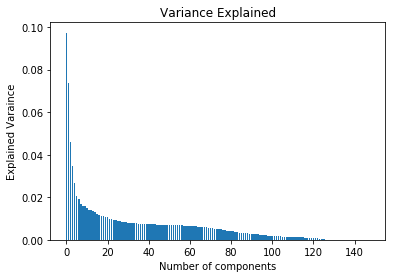

In [46]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_
val = np.arange(len(pca.explained_variance_ratio_))

plt.bar(val,variance)

plt.xlabel('Number of components')
plt.ylabel('Explained Varaince')
plt.title('Variance Explained')

plt.show()

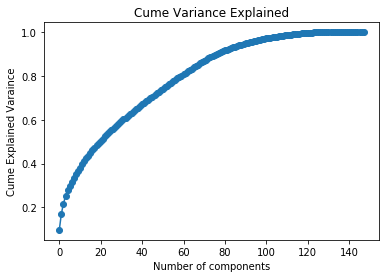

In [47]:
numcum = np.cumsum(variance)
plt.plot(val, numcum, marker = 'o')

plt.xlabel('Number of components')
plt.ylabel('Cume Explained Varaince')
plt.title('Cume Variance Explained')

plt.show()

In [110]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca30 = PCA(n_components = 30)
azdias_pca = pca30.fit_transform(azdias_scaler)

print(azdias_pca.shape)


(798061, 30)


### Discussion 2.2: Perform Dimensionality Reduction

Based on the graph, the elbow point (the point where we can capture most of the important information) is at about 20-30 components so I went with 30.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [111]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#need to define the columns for this to work

#used from Udacity course
def component_weight(df, pca, i):
    data = pd.DataFrame(pca.components_, columns = list(df.columns)).iloc[i]
    data.sort_values(ascending= False, inplace = True)
    return data



In [112]:
component_weight(azdias_scaler, pca30, 0)

LP_STATUS_GROB_1.0      0.200410
HH_EINKOMMEN_SCORE      0.187522
PLZ8_ANTG3              0.182096
WEALTH                  0.180492
PLZ8_ANTG4              0.175778
ORTSGR_KLS9             0.155963
EWDICHTE                0.154304
FINANZ_HAUSBAUER        0.148856
FINANZ_SPARER           0.131858
KBA05_ANTG4             0.130285
FINANZTYP_1.0           0.125621
LP_STATUS_FEIN_2.0      0.125272
PLZ8_ANTG2              0.125037
LP_STATUS_FEIN_1.0      0.124573
KBA05_ANTG3             0.118848
ANZ_HAUSHALTE_AKTIV     0.117003
ARBEIT                  0.113212
CAMEO_DEUG_2015_9       0.112388
RELAT_AB                0.107381
SEMIO_PFLICHT           0.098030
DECADE                  0.093815
SEMIO_REL               0.093167
LP_FAMILIE_GROB_1.0     0.091433
LP_FAMILIE_FEIN_1.0     0.091433
CAMEO_DEUG_2015_8       0.087570
ZABEOTYP_5.0            0.084264
SEMIO_RAT               0.082455
SEMIO_TRADV             0.073903
FINANZ_ANLEGER          0.069287
GEBAEUDETYP_3.0         0.068817
          

In [113]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_weight(azdias_scaler, pca30, 1)


ALTERSKATEGORIE_GROB     0.227585
FINANZ_VORSORGER         0.213321
ZABEOTYP_3.0             0.200694
SEMIO_ERL                0.178997
SEMIO_LUST               0.159702
RETOURTYP_BK_S           0.155054
W_KEIT_KIND_HH           0.127894
LP_STATUS_FEIN_1.0       0.107204
CJT_GESAMTTYP_2.0        0.105900
FINANZ_HAUSBAUER         0.099287
FINANZTYP_5.0            0.098345
FINANZTYP_2.0            0.086273
PLZ8_ANTG3               0.078285
PLZ8_ANTG4               0.076636
SEMIO_KRIT               0.076563
EWDICHTE                 0.076304
LP_FAMILIE_GROB_1.0      0.076279
LP_FAMILIE_FEIN_1.0      0.076279
ORTSGR_KLS9              0.075331
SHOPPER_TYP_3.0          0.072165
FINANZ_MINIMALIST        0.071931
WEALTH                   0.070456
CJT_GESAMTTYP_1.0        0.069673
FINANZTYP_6.0            0.065642
SEMIO_KAEM               0.063374
NATIONALITAET_KZ_1.0     0.062603
KBA05_ANTG4              0.062394
GFK_URLAUBERTYP_4.0      0.060017
ARBEIT                   0.057806
ANZ_HAUSHALTE_

In [114]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

component_weight(azdias_scaler, pca30, 2)

ANREDE_KZ                0.346628
SEMIO_VERT               0.319788
SEMIO_FAM                0.261745
SEMIO_SOZ                0.257642
SEMIO_KULT               0.252475
FINANZTYP_5.0            0.135924
FINANZ_MINIMALIST        0.126943
SHOPPER_TYP_0.0          0.123907
ZABEOTYP_1.0             0.113495
SEMIO_REL                0.113451
SEMIO_MAT                0.088825
RETOURTYP_BK_S           0.077150
MOVEMENT                 0.068326
GREEN_AVANTGARDE         0.068326
W_KEIT_KIND_HH           0.065775
ORTSGR_KLS9              0.063128
EWDICHTE                 0.062841
ZABEOTYP_6.0             0.051366
PLZ8_ANTG4               0.050263
PLZ8_ANTG3               0.050102
FINANZ_VORSORGER         0.049158
LP_STATUS_FEIN_1.0       0.047196
LP_STATUS_GROB_5.0       0.046776
LP_STATUS_FEIN_10.0      0.046776
LP_STATUS_FEIN_3.0       0.045084
PLZ8_ANTG2               0.036619
RELAT_AB                 0.036200
SHOPPER_TYP_1.0          0.035679
ARBEIT                   0.034746
NATIONALITAET_

### Discussion 2.3: Interpret Principal Components

Component 1: LP_STATUS_GROB_1.0 has a positive influence on this component while FINANZ_MINIMALIST has a negative influence
Component 2: ALTERSKATEGORIE_GROB has a positive influence on this component while DECADE has a negative influence
Component 3: ANREDE_KZ has a positive influence on this component while LP_STATUS_FEIN has a negative SEMIO_KAEM

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
# Over a number of different cluster counts...
centers = [2,4,6,8,10,12,14,16,18,20]
scores = []

for center in centers:
    kmeans = KMeans(n_clusters =center)
    kmeans.fit(azdias_pca)
    score = np.abs(kmeans.score(azdias_pca))
    scores.append(score)
    
print('Kmeans complete') 

Kmeans complete


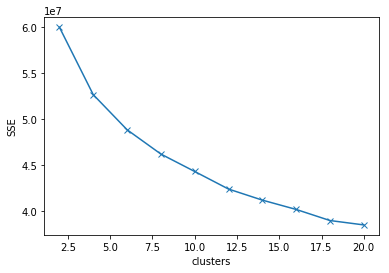

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, marker = 'x')
plt.xlabel("clusters")
plt.ylabel('SSE')
plt.show()


In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 16)
print('Kmeans cluster complete')



Kmeans cluster complete


In [56]:
kmeans = kmeans.fit(azdias_pca)
print('Fit Complete')

Fit Complete


In [57]:
general_kmeans = kmeans.predict(azdias_pca)
print('Predict complete')

Predict complete


### Discussion 3.1: Apply Clustering to General Population

When looking at the graph and looking for the elbow it looks like the elbow is at about 16.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';');
display(customers.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers, feat_info)


almost done
replace complete
drop complete
Clean complete


In [60]:
customers_cleaned.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,STAGE
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,1.0,1,3
2,4.0,0.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,1.0,3,4
3,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,0.0,2,4
4,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,0.0,4,1
5,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,5.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,1.0,3,4


In [61]:
list(set(azdias_pca)-set(customers_cleaned.columns))

[]

In [62]:
customers_cleaned.isnull().sum().sum()

0

In [67]:


customers_scaled = scaler.fit_transform(customers_cleaned)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_cleaned.columns.tolist())
customers_pca = azdias_pca

print('Scale Complete')

Scale Complete


In [69]:

#add kmeans

customer_pred = kmeans.predict(customers_pca)
print('Prediction Complete')

Prediction Complete


In [64]:
print('test')

test


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

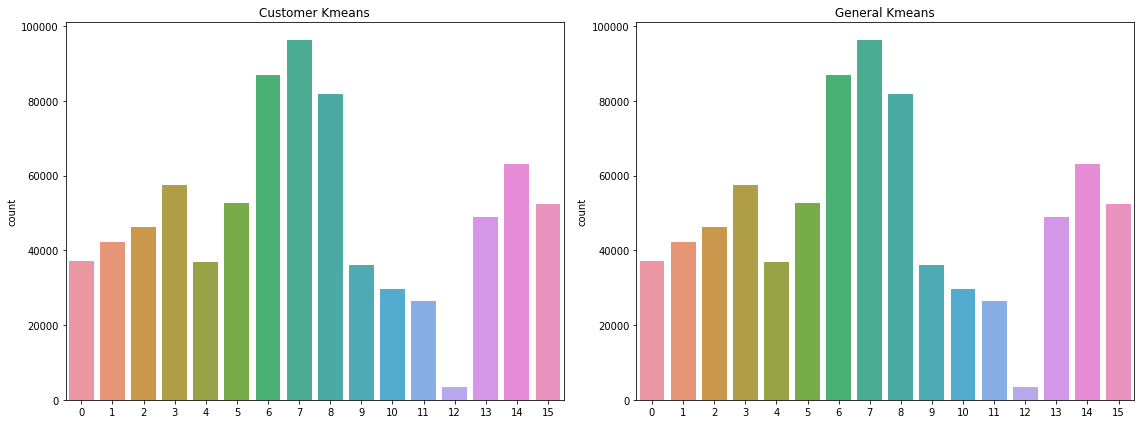

In [119]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(figsize = (16,6))

#customer data
ax1 = fig.add_subplot(121)
ax1.title.set_text('Customer Kmeans')
sns.countplot(customer_pred)

#general demo data
ax2 = fig.add_subplot(122)
ax2.title.set_text('General Kmeans')
sns.countplot(general_kmeans)

fig.tight_layout()

plt.show()

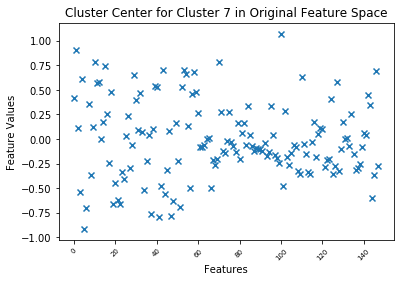

In [120]:
fix, ax = plt.subplots()
ax.scatter(range(len(cluster_center_original)), cluster_center_original, marker = 'x')
plt.xticks(rotation=45, fontsize=7)
plt.xlabel('Features')
plt.ylabel('Feature Values')
plt.title('Cluster Center for Cluster 7 in Original Feature Space')

plt.legend()
plt.show()

In [133]:
cluster_7 = kmeans.cluster_centers_[7]
pca_7 = pca30.inverse_transform(cluster_7)
over_rep = scaler.inverse_transform(pca_7)

ValueError: operands could not be broadcast together with shapes (148,) (76,) (148,) 

In [128]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



Shape of pca.inverse_transform(kmeans.cluster_centers_[7]): [  2.36706137e+00   2.70056613e+00   2.81841624e+00  -3.18766715e-01
   5.29016039e-01  -5.96438952e-02  -1.10706197e-01   4.04405907e-01
  -4.63699437e-01   6.57911728e-02  -4.55198705e-01   1.48421033e-01
   6.24888243e-02  -4.11950169e-01  -1.15616625e-01  -2.17915094e-01
   4.68817006e-02   3.75742314e-01  -2.95548754e-01   3.08427664e-01
  -1.50776034e-01   1.79770077e-01   1.51361827e-04   2.26636022e-03
  -1.25058874e-01   1.16989466e-01   1.67200763e-01   2.49198991e-01
  -3.60307015e-02  -2.53888531e-02]


AttributeError: 'NoneType' object has no attribute 'shape'

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the data above clusters of 7 in  is over represented

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.